In [54]:
import os
#import ipdb

import pandas as pd
import matplotlib as mpl
from matplotlib import lines
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns

EXP_NAME = "logs/proxies"
RESULTS_DIR = os.path.join( os.getcwd(),'results')

headers = ['time', 'elapsed', 'remotehost', 'code/status','bytes','method','URL','rfc931', 'peerstatus/peerhost','type'] 
headers = ['time', 'elapsed', 'bytes', 'URL', 'rfc931']

#Read input files from the directory and returns DataTable object in a combined list
def read_proxies():
    #Get list of nodes(files) with results
    INPUT_DIR = os.path.join( os.getcwd(), EXP_NAME)
    dirs = [f for f in os.listdir(INPUT_DIR) if os.path.isdir(os.path.join(INPUT_DIR, f))]
    #Load results from each node
    nodes_results = {}
    for sub_dir in dirs:
        nodes = [f for f in os.listdir(INPUT_DIR+'/'+sub_dir) if os.path.isfile(os.path.join(INPUT_DIR+'/'+sub_dir, f))]
        for node in nodes:
            file = os.path.join(INPUT_DIR+'/'+sub_dir,node)           
            print('reading:', file)
            try:
                temp = pd.read_csv(file, sep=' ', header=None, usecols=[0,1,4, 6,7])
                temp.columns = headers
                temp['time'] = pd.to_datetime(temp['time'], unit='s')
                temp.set_index('time')
                if sub_dir in nodes_results:
                    nodes_results[sub_dir] = pd.concat([nodes_results[sub_dir], temp])
                else:
                    nodes_results[sub_dir] = temp                    
            except Exception:
                print(node, 'EXception')
    return nodes_results

proxy_data = read_proxies()


reading: /home/khulan/proxyTest/logs/proxies/3982/3982_20171209_access_1.log
reading: /home/khulan/proxyTest/logs/proxies/3982/3982_20171222_access_0.log
reading: /home/khulan/proxyTest/logs/proxies/3982/3982_20171231_access_1.log
reading: /home/khulan/proxyTest/logs/proxies/3982/3982_20171217_access_1.log
reading: /home/khulan/proxyTest/logs/proxies/3982/3982_20171220_access_0.log
reading: /home/khulan/proxyTest/logs/proxies/3982/3982_20171206_access_0.log
reading: /home/khulan/proxyTest/logs/proxies/3982/3982_20171227_access_1.log
reading: /home/khulan/proxyTest/logs/proxies/3982/3982_20171226_access_0.log
reading: /home/khulan/proxyTest/logs/proxies/3982/3982_20171204_access_0.log
reading: /home/khulan/proxyTest/logs/proxies/3982/3982_20171203_access_1.log
reading: /home/khulan/proxyTest/logs/proxies/3982/3982_20171211_access_1.log
reading: /home/khulan/proxyTest/logs/proxies/3982/3982_20171230_access_0.log
reading: /home/khulan/proxyTest/logs/proxies/3982/3982_20171224_access_0.log

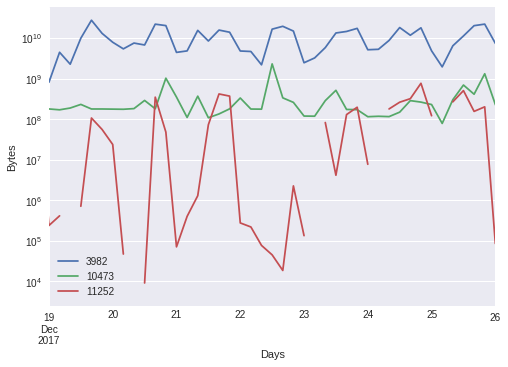

In [55]:
def plot_bytes_per_day(results, var):
    labels = []
    for key in results:
        df = results[key]
        df = df.set_index(df.time)        
        df_sample = df.resample('240Min').sum()        
        df_sample[(var)].plot(logy=True)        
        labels.append(key)
    plt.legend(labels)
    plt.xlabel('Days')
    plt.ylabel('Bytes')
    plt.xlim('19 December 2017','26 December 2017')
    plt.show()
    

def plot_request_numbers(results, var):
    labels =[]
    for key in results:
        df = results[key]
        df = df.set_index(df.time)        
        ecdf = getECDF(df,'bytes')
        labels.append(key)
        ecdf.plot()
    plt.legend(labels)
    plt.xlim(0, 10000)
    plt.xlabel('Request size (bytes)')
    plt.show()
    
def plot_hourly_request_size(results,var):  
    labels = []
    for key in results:
        df = results[key]
        df = df.set_index(pd.DatetimeIndex(df.time))
        df_sample = df.resample('60Min').mean()
        ecdf = getECDF(df_sample, var)
        ax = ecdf.plot(logx=True)
        labels.append(key)
    plt.legend(labels)
    plt.xlabel('Hourly request size (bytes)')
    plt.show()
    
def plot_hourly_request_number(results, var):
    labels = []
    for key in results:
        df = results[key]
        df = df.set_index(pd.DatetimeIndex(df.time))
        df_sample = df.resample('60Min').count()
        df_sample[(var)].plot()
        #ecdf = getECDF(df_sample, var)
        labels.append(key)
        #ecdf.plot()
    plt.legend(labels)
    plt.ylim(0,40000)
    plt.xlim('19 December 2017','26 December 2017')
    plt.xlabel('Number of hourly request')
    plt.show()
    
def plot_bytes_per_second(results,var):
    labels = []
    for key in results:
        df = results[key]       
        df = df.set_index(pd.DatetimeIndex(df.time))
        df = df.query('elapsed>0 & bytes>0')
        df['bytes_second'] = (df['bytes']/df['elapsed'])*1000
        #df = df.resample('60Min').mean()
        df[('bytes_second')].dropna(axis=0)
        df[('bytes_second')].plot()
        #print(type(df[('time','bytes_second')]))
        #df[['time','bytes_second']].plot()
        labels.append(key)
        #ecdf = getECDF(df, 'bytes_second')
        #ecdf.plot(logx=True)
    #plt.legend(labels)
    #plt.xlim('19 December 2017','26 December 2017')
    #plt.xlabel('Request processing throughput bytes/sec')
    #plt.show()

def plot_hourly_user_number(results, var):
    labels = []
    for key in results:
        df = results[key]
        df = df.set_index(pd.DatetimeIndex(df.time))
        df_grouped= df.groupby(['rfc931','time']).count()
        #df_grouped = df_grouped.set_index(pd.DatetimeIndex(df_grouped.time))
        df_resample = df.resample('60Min')
        print(df_grouped.head())

def getECDF(df, var):
    """Helper function that caclulates the ECDF of a dataframe"""
    df = df[var].value_counts()
    ecdf = df.sort_index().cumsum()*1./df.sum()
    return ecdf
    
plot_bytes_per_day(proxy_data,'bytes')
#plot_request_numbers(proxy_data,'bytes')
#plot_hourly_request_number(proxy_data,'bytes')
#plot_hourly_request_size(proxy_data,'bytes')
#plot_bytes_per_second(proxy_data,'bytes')
#plot_hourly_user_number(proxy_data, 'bytes')